# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal
### Projet A2024
----
Équipe T - TODO
### Objectif
Prédiction de **la consommation en carburant de voitures récentes**.

### Données
Le jeu de données contient pour presque 400 véhicule, la consommation moyenne en L/100km, l'année de frabrication, le type de véhicule, le nombre de cylindre, cylindree, la transmission et la boite.

- `train.csv` est l'ensemble d'entraînement
- `test.csv` est l'ensemble de test


## Chargement des données

Importation des librairies utilisées dans le calepin.

// TODO: à enlever à la fin:

Pour importer librairies:
using Pkg
Pkg.add(["CSV", "DataFrames", "Combinatorics", "Gadfly", "Distributions"], ...)

In [2]:
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("DecisionTree")

   Resolving package versions...
  No Changes to `C:\Users\franc\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\franc\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
   Installed ScikitLearnBase ─ v0.5.0
   Installed AbstractTrees ─── v0.4.5
   Installed DecisionTree ──── v0.12.4
    Updating `C:\Users\franc\.julia\environments\v1.10\Project.toml`
  [7806a523] + DecisionTree v0.12.4
    Updating `C:\Users\franc\.julia\environments\v1.10\Manifest.toml`
  [1520ce14] + AbstractTrees v0.4.5
  [7806a523] + DecisionTree v0.12.4
  [6e75b9c4] + ScikitLearnBase v0.5.0
Precompiling project...
  ✓ AbstractTrees
  ✓ ScikitLearnBase
  ✓ DecisionTree
  3 dependencies successfully precompiled in 6 seconds. 263 already precompiled.


In [3]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, DecisionTree,Random, Base

In [4]:
function standardize(data)
    return (data .- mean(data)) ./ std(data)
end

function standardize_data(data)
    stddata = deepcopy(data)
   for col in names(stddata)
        if eltype(stddata[!, col]) <: Number && col != "id"
            stddata[!, col] = standardize(stddata[!, col])
        end
    end
    return stddata
end

standardize_data (generic function with 1 method)

In [5]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end

function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :general_type)
    # encoded_data = encode(encoded_data, :annee)
    # encoded_data = encode(encoded_data, :type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    return encoded_data
end

encode_data (generic function with 1 method)

In [34]:
# faire une méthode pour les outliers
function get_outliers(data, columns)
    outliers = DataFrame()
    
    selected_data = data[:, columns]
    
    for col in names(selected_data)
        if eltype(selected_data[!, col]) <: Number

            Q1 = quantile(selected_data[!, col], 0.25)
            Q4 = quantile(selected_data[!, col], 0.75)
            IQR = Q4 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q4 + 1.5 * IQR
            
            # Debugging output for bounds
            println("col: ", col, " lower: ", lower_bound, " upper: ", upper_bound, " Q1: ", Q1, " Q4: ", Q4, " IQR: ", IQR)
            
            col_outliers = selected_data[(selected_data[!, col] .< lower_bound) .| (selected_data[!, col] .> upper_bound), :]
            outliers = vcat(outliers, col_outliers)
        end
    end
    
    return unique(outliers)
end

get_outliers (generic function with 2 methods)

In [7]:
function removeRows(data)
    return select!(data, Not([:type, :transmission, :boite, :general_type, :weight, :volume_gaz]))
    # return select!(data, Not([:annee]))
end

removeRows (generic function with 1 method)

In [8]:
function add_rows(data)
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]

    # https://www.insurancenavy.com/average-car-weight/
    # https://www.auto-tests.com/fr/lightest-weight/Wagon/all/
    weight_dict = Dict("voiture_moyenne" => 3300, "VUS_petit" => 3500, "voiture_compacte" => 2800, "voiture_deux_places" => 2800, "voiture_minicompacte" => 1500, "VUS_standard" => 5000, "monospace" => 4500, "voiture_sous_compacte" => 2600, "camionnette_petit" => 4200, "break_petit" => 2640, "voiture_grande" => 4400, "camionnette_standard" => 4700, "break_moyen" => 3300)
    data[!, :weight] = [weight_dict[t] for t in data[!, :type]]

    general_type_dict = Dict("voiture_moyenne" => "voiture", "VUS_petit" => "VUS", "voiture_compacte" => "voiture", "voiture_deux_places" => "voiture", "voiture_minicompacte" => "voiture", "VUS_standard" => "VUS", "monospace" => "camionnette", "voiture_sous_compacte" => "voiture", "camionnette_petit" => "camionnette", "break_petit" => "break", "voiture_grande" => "voiture", "camionnette_standard" => "camionnette", "break_moyen" => "break")
    data[!, :general_type] = [general_type_dict[t] for t in data[!, :type]]
    
    # display(plot(data, x=:general_type, y=:consommation, color=:type))
    # println(combine(groupby(data, :type), nrow => :count))
    return data
end

add_rows (generic function with 1 method)

In [9]:
function getStandardEncodedData(data)
    data_copy = deepcopy(data)
    standardised_data = add_rows(data_copy)
    standardised_data = standardize_data(data_copy)
    standardised_data = encode_data(standardised_data)
    standardised_data = removeRows(standardised_data)
    
    # print(standardised_data)
    return standardised_data
end




getStandardEncodedData (generic function with 1 method)

In [10]:
function rmse(y, ychap)
    return sqrt(mean((ychap .- y).^2))
end


rmse (generic function with 1 method)

In [11]:
function rsquared(y, ychap)
    ss_total = sum((y .- mean(y)).^2)
    ss_res = sum((y .- ychap).^2)
    return ss_res / ss_total
end


rsquared (generic function with 1 method)

In [12]:
function train_test_split(data, test_size=0.2, shuffle=true)
    n = size(data, 1)
    test_size = floor(Int, n * test_size)
    
    if shuffle
        indices = randperm(n)
    else
        indices = 1:n
    end
    
    test_indices = indices[1:test_size]
    train_indices = indices[test_size+1:end]
    
    train_data = data[train_indices, :]
    test_data = data[test_indices, :]
    
    return train_data, test_data
end

train_test_split (generic function with 3 methods)

In [13]:
trainData = CSV.read("./data/train.csv", DataFrame)
testData = CSV.read("./data/test.csv", DataFrame)
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => "."))
testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))


COMSOMMATION_MEAN = mean(trainData.consommation)
COMSOMMATION_STD = std(trainData.consommation)
trainData[!, :id] = 1:nrow(trainData)
testData[!, :id] = 1:nrow(testData)

possibles = unique(trainData.consommation)


25-element Vector{Float64}:
 13.8358823529412
  9.80041666666667
 11.7605
 13.0672222222222
  7.3503125
  7.58741935483871
 11.2004761904762
 14.700625
 12.3794736842105
 10.6913636363636
  9.4084
 15.6806666666667
  8.71148148148148
  8.11068965517241
 10.2265217391304
  7.84033333333333
  8.40035714285714
  9.04653846153846
 16.8007142857143
  6.91794117647059
  6.35702702702703
  4.52326923076923
  7.12757575757576
  4.90020833333333
  6.53361111111111

In [14]:
# function evaluate_rmse()
#     data = getStandardEncodedData(trainData)
#     nrange = 1000
#     n = 0
#     for i in range(0, 1, length=nrange)
#         n += regression(data, 0.05)[1]
#     end
#     print("average rmse for regression: ", n/nrange, "\n")

#     n = 0
#     for i in range(0, 1, length=nrange)
#         n += ridge_regression(data, 0.1, 0.05)[1]
#     end
#     print("average rmse for ridge: ", n/nrange, "\n")

#     n = 0
#     for i in range(0, 1, length=nrange)
#         n += svd_regression(data, 0.05)[1]
#     end
#     print("average rmse for svd: ", n/nrange, "\n")

#     nrange = 1000
#     n = 0
#     for i in range(0, 1, length=nrange)
#         n += polynomial_regression(data,2, 0.05)[1]
#     end
#     print("average rmse for polynomial regression: ", n/nrange, "\n")

# end


In [15]:


# function predict(data, beta)
#     return (Matrix(data[:, Not(:consommation, :id)]) * beta)
# end

# function destandardize(data)
#     return (data .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
# end

# function predict_and_destandardize(data, beta)
#     return destandardize(predict(data, beta))
# end



# function find_mistakes(data_to_predict, beta, col)
#     prediction = (Matrix(data_to_predict[:, Not(:consommation, :id)]) * beta)
#     prediction = (prediction .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
#     data_to_predict[!,:consommation] = data_to_predict[!,:consommation] .* COMSOMMATION_STD .+ COMSOMMATION_MEAN

#     idtrain = 1:size(prediction, 1)

#     base_data_of_predicted = innerjoin(data_to_predict, trainData, on=:id, makeunique=true)

#     scatter(idtrain, prediction)
#     scatter!(idtrain, base_data_of_predicted[!,:consommation])


#     difference = prediction - base_data_of_predicted[!,:consommation]
#     base_data_of_predicted[!, :difference] = difference
#     diff_cutoff = 1
#     high_diff_rows = base_data_of_predicted[abs.(difference) .> diff_cutoff, :]

#     grouped_normal = combine(groupby(base_data_of_predicted, col), nrow => :count)

#     grouped_high_diff = combine(groupby(high_diff_rows, col), nrow => :count)

#     grouped_high_diff[!, :total_diff] = combine(groupby(high_diff_rows, col), :difference => (x -> sum(abs.(x))) => :total_diff)[:, :total_diff]

#     max_diff = combine(groupby(high_diff_rows, col), :difference => (x -> maximum(abs.(x))) => :max_diff)

#     grouped_high_diff = leftjoin(grouped_high_diff, max_diff, on=col)
#     grouped_high_diff[!, :average_diff] = combine(groupby(high_diff_rows, col), :difference => (x -> mean(abs.(x))) => :average_abs_diff)[:, :average_abs_diff]

#     grouped_high_diff[!, :rmse] = combine(groupby(high_diff_rows, col), :difference => (x -> sqrt(mean(x.^2))) => :rmse)[:, :rmse]
#     grouped_normal[!, :rmse] = combine(groupby(base_data_of_predicted, col), :difference => (x -> sqrt(mean(x.^2))) => :rmse)[:, :rmse]

#     percentage_high_diff = leftjoin(grouped_high_diff, grouped_normal, on=col, makeunique=true)
#     percentage_high_diff[!, :percentage] = percentage_high_diff[!, :count] ./ percentage_high_diff[!, :count_1] .* 100
#     percentage_high_diff = sort(percentage_high_diff, :percentage, rev=true)

#     println("Percentage of data by ", col," with difference higher than 1: ")
#     println(percentage_high_diff[:, [col, :percentage, :count, :count_1, :total_diff, :max_diff, :average_diff, :rmse]])

#     grouped_normal = sort(grouped_normal, :rmse, rev=true)

#     println(grouped_normal[:, [col, :count, :rmse]])
# end




In [16]:
# rmseval, betatrain, traindata, testpredictdata = regression(data, 0.2)
# find_mistakes(testpredictdata, betatrain, :annee)

In [17]:
# beta = ridge_regression(data, 10, 0.0)[2]
# function remise_regression(beta)
#     test_data = getStandardEncodedData(testData)
#     X_test = Matrix(test_data[!,Not(:id)])
#     ychap =  X_test * beta
#     ychap = (ychap .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
#     remise(ychap)
# end
function remise(prediction)
    id = 1:150
    df_pred = DataFrame(id=id, consommation=prediction)

   format_file(df_pred)
end

function format_file(predictions)
    println(predictions)
    current_time = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
    file_name = "benchmark_" * current_time * ".csv"
    CSV.write("./soumissions_potentielles/" *file_name, predictions)
end

format_file (generic function with 1 method)

In [18]:
# findnearest(A::Vector{Float64},t::Float64) = A[findmin(broadcast(abs,A.-t))[2]]

function findnearest(A::Vector{Float64},t::Float64)
    nearest_value = A[1]
    smallest_diff = abs(A[1] - t)
    for value in A
        diff = abs(value - t)
        if diff < smallest_diff
            smallest_diff = diff
            nearest_value = value
        end
    end
    if smallest_diff > 0.3
        # println("Warning: the nearest value is ", nearest_value, " the value was ", t," with a difference of ", smallest_diff)
    end
    return nearest_value
    
end

function forest(data)
    train, test= train_test_split(data)

    X_train =  Matrix(train[:, Not(:consommation, :id)])
    y_train = train.consommation
    X_test = Matrix(test[:, Not(:consommation, :id)])
    y_test = test.consommation


    model = RandomForestRegressor(n_subfeatures=12, n_trees=1000,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_test)

    train_consommation = (test.consommation * COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    y_pred = (y_pred * COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    # println(size(y_pred))
    # println(unique(y_pred))
    # println(size(unique(y_pred)))
    #println(y_pred)
    # y_pred = map(x -> findnearest(possibles,x),y_pred)
    # println(y_pred_adjusted)
    # println(y_pred)
    # println(test.consommation)
    return sqrt(mean((y_pred - train_consommation).^2)), y_pred
end

function forest_predict(train, predict)
    X_train =  Matrix(train[:, Not(:consommation)])
    y_train = train.consommation
    X_predict = Matrix(predict[:, Not(:id)])
    # println(X_train)
    # println(y_train)
    # println(X_predict)

    model = RandomForestRegressor(n_subfeatures=12, n_trees=1000,min_samples_leaf=1,min_purity_increase=0.0, max_depth=10, min_samples_split=6)
    DecisionTree.fit!(model, X_train, y_train)
    y_pred = DecisionTree.predict(model, X_predict)

    y_pred = (y_pred * COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    # y_pred = map(x -> findnearest(possibles,x),y_pred)
    # println(y_pred)
    return y_pred
end

forest_predict (generic function with 1 method)

In [19]:
function evaluate_rmse(data)
    n = 0
    for i in 1:100
        val = forest(data)[1]
        n += val
        # println(val)
    end
    println(n/100)
end

evaluate_rmse (generic function with 1 method)

In [20]:
# function find_duplicates(data)
#     data_without_consommation = select(data, Not(:consommation, :id, :annee))
#     # println(data_without_consommation)
#     return data[findall(x -> count(==(x), eachrow(data_without_consommation)) > 1, eachrow(data_without_consommation)), :]
# end

function get_unique_data(data)
    data_without_consommation = select(data, Not(:consommation, :id, :annee))

   
    unique_data = combine(groupby(data, names(data_without_consommation)), :consommation => mean)
    rename!(unique_data, :consommation_mean => :consommation)
    return unique_data
end

function find_pairs(data_train, data_predict)
    train_data_without_consommation = select(data_train, Not(:consommation))
    predict_data_without_consommation = select(data_predict, Not( :annee))

    common_values = innerjoin(data_train, predict_data_without_consommation, on=names(train_data_without_consommation))

    println(common_values.id)
    # common_values = intersect(data_train, data_predict)
    return common_values
end

function find_differents(data_train, data_predict)
    different_values = antijoin(data_predict, data_train, on=["type", "nombre_cylindres", "cylindree", "transmission", "boite"])
    println(different_values.id)
    return different_values
    
end

function predict_with_dups(data_train, data_predict)
    pairs = find_pairs(data_train, data_predict)
    pairs = select(pairs, [:id, :consommation])
    different_values = find_differents(data_train, data_predict)

    # println(data_train)

    trainDataStandard = getStandardEncodedData(data_train)
    predictDataStandard = getStandardEncodedData(different_values)
    # println(predictDataStandard)
    different_values[!, :consommation] = forest_predict(trainDataStandard,predictDataStandard)
    # println(different_values)
    different_values = select(different_values, [:id, :consommation])
    prediction = vcat(pairs, different_values)
    prediction = sort(prediction, :id)
    # println(prediction)
    return prediction
end
    

predict_with_dups (generic function with 1 method)

In [37]:
function linear_regression(data, x_col, y_col)
    # Extract x and y data from the DataFrame
    x = data[!, x_col]
    y = data[!, y_col]
    
    # Ensure there is enough data for the calculation
    n = length(x)
    if n == 0
        error("Cannot compute linear regression with zero elements.")
    end
    
    # Calculate the mean values
    x_mean = mean(x)
    y_mean = mean(y)
    
    # Calculate slope and intercept for linear regression
    slope = sum((x .- x_mean) .* (y .- y_mean)) / sum((x .- x_mean).^2)
    intercept = y_mean - slope * x_mean
    
    return slope, intercept
end

linear_regression (generic function with 1 method)

In [90]:

function get_outliers_ind_regression_lin(data, x_col, y_col; threshold=2.5)
    slope, intercept = linear_regression(data, x_col, y_col)
    
    x = data[!, x_col]
    y = data[!, y_col]
    
    y_pred = slope .* x .+ intercept
    
    residuals = abs.(y .- y_pred)
    
    residuals_std = std(residuals)
    
    outlier_indices = findall(residuals .> threshold * residuals_std)
    

    for idx in outlier_indices
        println("Outlier detected at row $idx: ", "x = ", x[idx], ", y = ", y[idx], ", Residual = ", residuals[idx])
    end

    outliers = data[outlier_indices, :]
    
    return outlier_indices
end


get_outliers_ind_regression_lin (generic function with 1 method)

In [91]:
function get_outliers_regression_lin(data, outliers_indices)
    outliers = data[outliers_indices, :]
    return outliers
end;

In [92]:
function remove_outliers_regression_lin(data::DataFrame, x_col::Symbol, y_col::Symbol; threshold=2.5)
    outlier_indices = get_outliers_ind_regression_lin(data, x_col, y_col, threshold=threshold)

    println("Outlier Indices Identified: ", outlier_indices)

    keep_mask = trues(nrow(data))
    
    if !isempty(outlier_indices)
        keep_mask[outlier_indices] .= false
    end

    cleaned_data = data[keep_mask, :]
    
    return cleaned_data
end

remove_outliers_regression_lin (generic function with 2 methods)

[43, 87, 100, 108, 128, 135, 142, 54, 81, 134, 148, 30, 37, 38, 55, 56, 57, 109, 3, 32, 2, 65, 106, 26, 28, 113, 33, 47, 79, 30, 37, 38, 55, 56, 33, 47, 79, 13, 82, 114, 143, 30, 37, 38, 55, 56, 136, 61, 146, 81, 93, 145, 61, 146, 43, 87, 100, 108, 128, 135, 142, 129, 50, 129, 103, 29, 141, 129, 117, 150, 7, 43, 87, 100, 108, 128, 135, 142, 13, 82, 114, 143, 43, 87, 100, 108, 128, 135, 142, 117, 150, 65, 106, 129, 43, 87, 100, 108, 128, 135, 142, 149, 13, 82, 114, 143, 129, 26, 28, 83, 90, 93, 131, 58, 127, 133, 138, 144, 145, 29, 141, 27, 62, 59, 127, 133, 138, 144, 35, 92, 4, 84, 85, 101, 46, 102, 43, 87, 100, 108, 128, 135, 142, 54, 43, 87, 100, 108, 128, 135, 142, 148, 74, 89, 94, 95, 27, 13, 82, 114, 143, 9, 126, 137, 121, 21, 24, 116, 130, 59, 96, 97, 30, 37, 38, 55, 56, 50, 89, 94, 95, 2, 139, 43, 87, 100, 108, 128, 135, 142, 57, 109, 53, 92, 14, 83, 62, 13, 82, 114, 143, 83, 61, 146, 36, 66, 67, 50, 54, 81, 57, 109, 60, 123, 3, 32, 41, 1, 15, 76, 105, 129, 6, 102, 46, 31, 34, 8

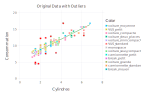

Outlier detected at row 18: x = 2.5, y = 7.595322916666666, Residual = 1.986619363435528
Outlier detected at row 48: x = 4.2, y = 16.8007142857143, Residual = 4.520202314107941
Outlier detected at row 50: x = 2.0, y = 12.215724032302967, Residual = 3.4274787202902335
Outlier detected at row 57: x = 3.0, y = 12.837972709551634, Residual = 2.4623334613599805
Outlier detected at row 64: x = 6.2, y = 13.10767801857585, Residual = 2.347621825388348
Outlier detected at row 79: x = 1.8, y = 4.52326923076923, Residual = 3.9474972940077198
Outlier detected at row 84: x = 1.5, y = 4.90020833333333, Residual = 3.094340010589944
Outlier detected at row 106: x = 2.5, y = 12.3794736842105, Residual = 2.797531404108307
Outlier detected at row 136: x = 1.5, y = 4.52326923076923, Residual = 3.4712791131540435
Outlier detected at row 145: x = 3.5, y = 7.84033333333333, Residual = 3.3290028829477833
Outlier Indices Identified: [18, 48, 50, 57, 64, 79, 84, 106, 136, 145]


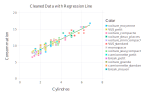

In [93]:
function main()
    # println(find_duplicates(trainData))

    # Step 1: Get Unique Data
    uniqueD = get_unique_data(trainData)
    
    # find_pairs(uniqueD, testData)

    # print(uniqueD)
    # print(trainData[!, Not(:id, :annee)])

    # println(uniqueD)
    predict_with_dups(trainData[!, Not(:id, :annee)], testData)

    # format_file(predict_with_dups(uniqueD, testData))
    # uniqueD[!,:volume_gaz] = uniqueD[!,:nombre_cylindres] .* uniqueD[!,:cylindree]
    # uniqueD

    #outliers = get_outliers(uniqueD, [:cylindree, :consommation])

    # Step 2: Find and Display Outliers with Regression
    outliers_indices = get_outliers_ind_regression_lin(uniqueD, :cylindree, :consommation)
    outliers_regression = get_outliers_regression_lin(uniqueD, outliers_indices)

    # Step 3: Plot Original Data, Regression Line, and Outliers
    slope, intercept = linear_regression(uniqueD, :cylindree, :consommation)
    regression_line_y = slope .* uniqueD.cylindree .+ intercept

    layer_original = layer(x=uniqueD.cylindree, y=uniqueD.consommation, color=uniqueD.type, Theme(default_color="blue"))
    layer_linear_regression = layer(x=uniqueD.cylindree, y=regression_line_y, Geom.line, Theme(default_color="green"))
    layer_regression_outliers = layer(x=outliers_regression.cylindree, y=outliers_regression.consommation, Geom.point, Theme(default_color="red"))

    
    display(plot(layer_regression_outliers, layer_original, layer_linear_regression, Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Original Data with Outliers")))

    # Step 4: Remove Outliers Based on Regression Line
    cleaned_data = remove_outliers_regression_lin(uniqueD, :cylindree, :consommation, threshold=2.5)

    # Step 5: Plot Cleaned Data with New Regression Line
    slope_cleaned, intercept_cleaned = linear_regression(cleaned_data, :cylindree, :consommation)
    regression_line_y_cleaned = slope_cleaned .* cleaned_data.cylindree .+ intercept_cleaned

   layer_cleaned = layer(x=cleaned_data.cylindree, y=cleaned_data.consommation, color=cleaned_data.type, Theme(default_color="blue"))
   layer_linear_regression_cleaned = layer(x=cleaned_data.cylindree, y=regression_line_y_cleaned, Geom.line, Theme(default_color="green"))

   # Display plot for cleaned data
   display(plot(layer_cleaned, layer_linear_regression_cleaned, 
                Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Cleaned Data with Regression Line")))

    
    # scatter(uniqueD.volume_gaz, uniqueD.consommation, zcolor=uniqueD.type)
    # trainDataStandard = getStandardEncodedData(trainData)

    # predictDataStandard = getStandardEncodedData(testData)
    # evaluate_rmse(trainDataStandard)
    # forest_predict(trainDataStandard,predictDataStandard)
end
main()

In [ ]:
# for type in unique(trainData.type)
#     println(type)
#     data_type = trainData[trainData.type .== type, :]
#     println(combine(groupby(data_type, :transmission), :consommation => mean, :volume_gaz => mean, nrow => :nrow))
#     println()
# end

voiture_moyenne


LoadError: ArgumentError: column name :volume_gaz not found in the data frame

In [ ]:
# for type in unique(trainData.type)
#     println(type)
#     data_type = trainData[trainData.type .== type, :]
#     display(plot(x=data_type.volume_gaz, y=data_type.consommation))
#     println()
# end

voiture_moyenne


LoadError: ArgumentError: column name :volume_gaz not found in the data frame

## Exploration des données